In [1]:
%matplotlib notebook
# %matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

### Kernels and their derivatives w.r.t parameters

In [2]:
def sqexp(x, xp, params):#tau1=1.0,tau2 = 1.0, l1=3.0, l2=2.0):
    """Squared exponential kernel (1 dimensional)
    
    Inputs
    ------
    x : (N), array of multiple inputs
    xp: float
    
    Returns
    -------
    cov (N,) -- Covariance between each input at *x* and the function values at *x*
    """
    tau = params[0]
    l1 = params[1]
    l2 = params[2]
    Q = np.diag([1/l1,1/l2])
    cov = tau**2 * np.exp(-1/2 * (x-xp).T @ Q @ (x-xp))
    return cov

def dsqexp_dtau(x,xp,params):
    tau = params[0]
    l1 = params[1]
    l2 = params[2]
    Q = np.diag([1/l1,1/l2])
    dcov_d = 2 * tau * np.exp(-1/2 * (x-xp).T @ Q @ (x-xp))
    return dcov_d

def dsqexp_dl1(x,xp,params):
    tau = params[0]
    l1 = params[1]
    l2 = params[2]
    Q = np.diag([1/l1,1/l2])
    dQ_dl1 = np.diag([-1/l1/l1,0])
    dcov_d = tau**2 * np.exp(-1/2 * (x-xp).T @ dQ_dl1 @ (x-xp))
    return dcov_d

def dsqexp_dl2(x,xp,params):
    tau = params[0]
    l1 = params[1]
    l2 = params[2]
    dQ_dl2 = np.diag([0,-1/l2/l2])
    dcov_d = tau**2 * np.exp(-1/2 * (x-xp).T @ dQ_dl2 @ (x-xp))
    return dcov_d

def periodic(x, xp, params):#tau=1, l=1.0, p=0.4):
    """Periodic kernel"""
    tau = params[0]; l = params[1]; p = params[2];
    return tau**2 * np.exp ( -2 * np.sin(np.pi * np.abs(x - xp) / p )**2 / l**2)
def poly(x, xp, c=1, d=3):
    """Polynomial kernel"""
    c = params[0]; d = params[1];
    return (x * xp + c)**d
    
KERNELS = {"Sq.Exp":sqexp, "Periodic":periodic, "Poly":poly}

### Build Covariance matrix and its derivatives

In [3]:
def build_covariance(x, xp, kern, params):
    """Build a covariance matrix
    
    Inputs
    -------
    x: (N) array of inputs
    xp: (M) array of inptus
    kern: a function mapping inputs to covariance
    
    Outputs
    -------
    cov: (N, M) covariance matrix
    """
    out = np.zeros((x.shape[0], xp.shape[0]))
    for jj in range(xp.shape[0]):
        for ii in range(x.shape[0]):
            out[ii, jj] = kern(x[ii], xp[jj], params)
    return out

def build_covariance_gradient(x, xp, kern, params):
    out_tau = np.zeros((x.shape[0], xp.shape[0]))
    out_l1 = np.zeros((x.shape[0], xp.shape[0]))
    out_l2 = np.zeros((x.shape[0], xp.shape[0]))
    for jj in range(xp.shape[0]):
        for ii in range(x.shape[0]):
            out_tau[ii, jj] = dsqexp_dtau(x[ii], xp[jj], params)
            out_l1[ii, jj] = dsqexp_dl1(x[ii], xp[jj], params)
            out_l2[ii, jj] = dsqexp_dl2(x[ii], xp[jj], params)
    return out_tau, out_l1, out_l2

In [4]:
def gpr(xtrain, ytrain, xpred, noise_var, mean_func, kernel, params = None):
    """Gaussian process regression Algorithm

    Inputs
    -------
    xtrain: (N, ) training inputs
    ytrain: (N, ) training outputs
    xpred:  (M, ) locations at which to make predictions
    noise_var: (N, ) noise at every training output
    mean_func: function to compute the prior mean
    kernel: covariance kernel
    
    Returns
    -------
    pred_mean : (M, ) predicted mean at prediction points
    pred_cov : (M, M) predicted covariance at the prediction points
    --
    """
    
    cov = build_covariance(xtrain, xtrain, kernel, params)
    u, s, v = np.linalg.svd(cov)
    sqrtcov = np.dot(u, np.sqrt(np.diag(s)))

    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(cov + np.diag(noise_var))
    
    vec_pred = build_covariance(xpred, xtrain, kernel, params)

    pred_mean = mean_func(xpred) + vec_pred @ invcov @ (ytrain - mean_func(xtrain))
    
    cov_predict_pre = build_covariance(xpred, xpred, kernel, params)
    cov_predict_up = vec_pred @ invcov @ vec_pred.T
    pred_cov = cov_predict_pre - cov_predict_up
    
    # Sometimes the values are small negaive, example -1e-5, just make them 0. probably due to inaccurate matrix inversion operations
    pred_cov[ pred_cov < 0 ] = 0
    
    return pred_mean, pred_cov

In [27]:
from scipy.optimize import minimize
# Minimize negative log likelihood for hyparameter optimization

def negative_log_likelihood(params):
    
    #### Uncomment out which one to train for
    
    # First data
#     train_x0 = np.asarray([0.1, -0.9, 0.2, 0.8 ,-0.6, 0.3, 0.5, -0.5, -0.01, -0.9])
#     train_y0 = np.asarray([0.05, 0.3, 0.4, -0.3 ,0.3, -0.2 ,-0.84 ,0.85, -0.7, -0.9])
#     ytrain = np.asarray([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928 ,2.7968011, 3.34929734, 3.9129616]).reshape(-1,1);

    # Second data
    train_x0 = np.asarray([0.1, -0.9, 0.2, 0.8 ,-0.6, 0.3, 0.5, -0.5, -0.01, -0.9, 4.500000000000000111e-01, 7.199999999999999734e-01, -8.000000000000000444e-01, -8.000000000000000444e-01])
    train_y0 = np.asarray([0.05, 0.3, 0.4, -0.3 ,0.3, -0.2 ,-0.84 ,0.85, -0.7, -0.9, 6.500000000000000222e-01, -6.400000000000000133e-01, -6.500000000000000222e-01, 5.999999999999999778e-01])
    ytrain = np.asarray([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928 ,2.7968011, 3.34929734, 3.9129616, 3.368086692765749124e+00, 3.752857874639865532e+00, 3.420476373601408770e+00, 3.040183158829708354e+00]).reshape(-1,1);
    
    # Third data
    
    # Fourth data
    
    xtrain = np.concatenate((train_x0.reshape(-1,1),train_y0.reshape(-1,1)),axis=1)
    kernel = sqexp
    cov = build_covariance(xtrain, xtrain, kernel, params)
    n = np.shape(cov)[0]  # assuming a square matrix
    noise_var = 0.001
    # mean function in lecture notebooks is directly taken as 0 in subsequent code
    log_likelihood = -1/2*( ytrain - np.zeros((xtrain.shape[0],1)) ).T @ np.linalg.inv(cov + noise_var*np.eye(n)) @ ( ytrain - np.zeros((xtrain.shape[0],1))) - 1/2*np.log( np.linalg.det(cov + noise_var*np.eye(n)) ) - n/2*np.log(2*np.pi)
    return -log_likelihood[0,0]

def negative_log_likelihood_gradient(params):
    
#     # First data
#     train_x0 = np.asarray([0.1, -0.9, 0.2, 0.8 ,-0.6, 0.3, 0.5, -0.5, -0.01, -0.9])
#     train_y0 = np.asarray([0.05, 0.3, 0.4, -0.3 ,0.3, -0.2 ,-0.84 ,0.85, -0.7, -0.9])
#     ytrain = np.asarray([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928 ,2.7968011, 3.34929734, 3.9129616]).reshape(-1,1);

    # Second data
    train_x0 = np.asarray([0.1, -0.9, 0.2, 0.8 ,-0.6, 0.3, 0.5, -0.5, -0.01, -0.9, 4.500000000000000111e-01, 7.199999999999999734e-01, -8.000000000000000444e-01, -8.000000000000000444e-01])
    train_y0 = np.asarray([0.05, 0.3, 0.4, -0.3 ,0.3, -0.2 ,-0.84 ,0.85, -0.7, -0.9, 6.500000000000000222e-01, -6.400000000000000133e-01, -6.500000000000000222e-01, 5.999999999999999778e-01])
    ytrain = np.asarray([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928 ,2.7968011, 3.34929734, 3.9129616, 3.368086692765749124e+00, 3.752857874639865532e+00, 3.420476373601408770e+00, 3.040183158829708354e+00]).reshape(-1,1);
        
    # Third data
    
    # Fourth data
    
    xtrain = np.concatenate((train_x0.reshape(-1,1),train_y0.reshape(-1,1)),axis=1)
    kernel = sqexp
    cov = build_covariance(xtrain, xtrain, kernel, params)
    dK_dtau, dK_dl1, dK_dl2 = build_covariance_gradient(xtrain, xtrain, kernel, params)
    n = np.shape(cov)[0]  # assuming a square matrix
    noise_var = 0.001
    K_inv = np.linalg.inv(cov + noise_var*np.eye(n))
    dL_dtau = 1/2*ytrain.T @ K_inv @ dK_dtau @ K_inv @ ytrain - 1/2* np.trace( K_inv @ dK_dtau )
    dL_dl1 = 1/2*ytrain.T @ K_inv @ dK_dl1 @ K_inv @ ytrain - 1/2* np.trace( K_inv @ dK_dl1 )
    dL_dl2 = 1/2*ytrain.T @ K_inv @ dK_dl2 @ K_inv @ ytrain - 1/2* np.trace( K_inv @ dK_dl1 )
    
    return np.array([-dL_dtau[0,0], -dL_dl1[0,0], -dL_dl2[0,0]])

def train_gp():
    #tau1, tau2, l1, l2
    kernel_params = np.array([1.0,3.0, 2.0]) # initial estimate
    res = minimize(negative_log_likelihood, kernel_params, method='BFGS', jac=negative_log_likelihood_gradient, options={'xatol': 1e-8, 'disp': True})
    
    # Return optimized parameters
    return res.x

# For testing
params = train_gp()
print(negative_log_likelihood(params))
print(params)
print(negative_log_likelihood([1.0,3.0,3.0])) #initial parameter: see that value is more than returned optimized values

/home/hardik/Dropbox (University of Michigan)/Semesters/Semester 3/AEROSP 567 Inf Est & Learning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:63: OptimizeWarning: Unknown solver options: xatol
/home/hardik/Dropbox (University of Michigan)/Semesters/Semester 3/AEROSP 567 Inf Est & Learning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log
/home/hardik/Dropbox (University of Michigan)/Semesters/Semester 3/AEROSP 567 Inf Est & Learning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log


         Current function value: 73.159843
         Iterations: 1
         Function evaluations: 21
         Gradient evaluations: 19
73.15984280090576
[1.77003136 3.65001167 2.06809213]
131.923744357326


## Process given data 0

In [25]:
train_x0 = np.asarray([0.1, -0.9, 0.2, 0.8 ,-0.6, 0.3, 0.5, -0.5, -0.01, -0.9])
train_y0 = np.asarray([0.05, 0.3, 0.4, -0.3 ,0.3, -0.2 ,-0.84 ,0.85, -0.7, -0.9])
train_output0 = np.asarray([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928 ,2.7968011, 3.34929734, 3.9129616]).reshape(-1,1);
train_input0 = np.concatenate((train_x0.reshape(-1,1),train_y0.reshape(-1,1)),axis=1)

# generate test data
num_div = 50
x = np.linspace(-1,1,num_div)#.reshape(-1,1)
y = np.linspace(-1,1,num_div)#.reshape(-1,1)
X, Y = np.meshgrid(x,y)

# converting from meshgrid format to a list of points
pred_input = np.concatenate((X.reshape(-1,1),Y.reshape(-1,1)),axis=1)

noise_cov = 0.001
mean_func = lambda x: np.zeros((x.shape[0],1))

# params = [1.0,3.0,3.0]
params = train_gp()
mean, cov = gpr(train_input0, train_output0, pred_input, noise_cov * np.ones((train_input0.shape[0])), mean_func, sqexp, params)
# mean, cov = gpr(train_input0, train_output0, pred_input, noise_cov * np.ones((train_input0.shape[0])), mean_func, sqexp)


/home/hardik/Dropbox (University of Michigan)/Semesters/Semester 3/AEROSP 567 Inf Est & Learning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:63: OptimizeWarning: Unknown solver options: xatol


         Current function value: 79.596813
         Iterations: 1
         Function evaluations: 58
         Gradient evaluations: 46


### Plot given data 0

<IPython.core.display.Javascript object>


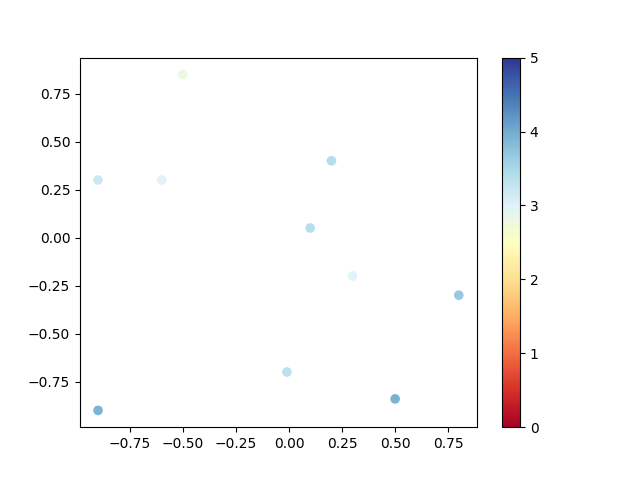

<IPython.core.display.Javascript object>


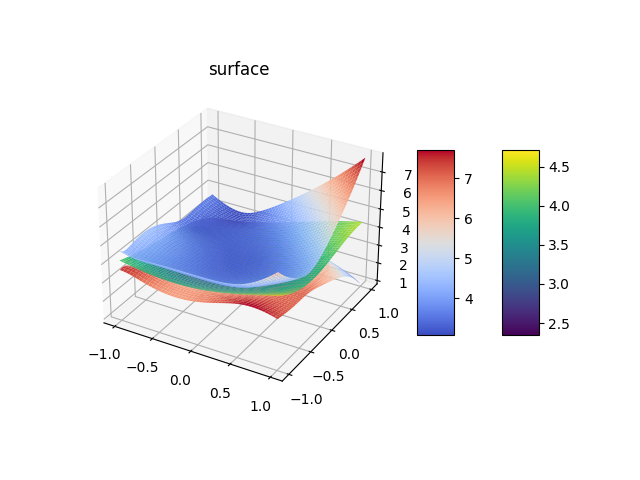

<IPython.core.display.Javascript object>


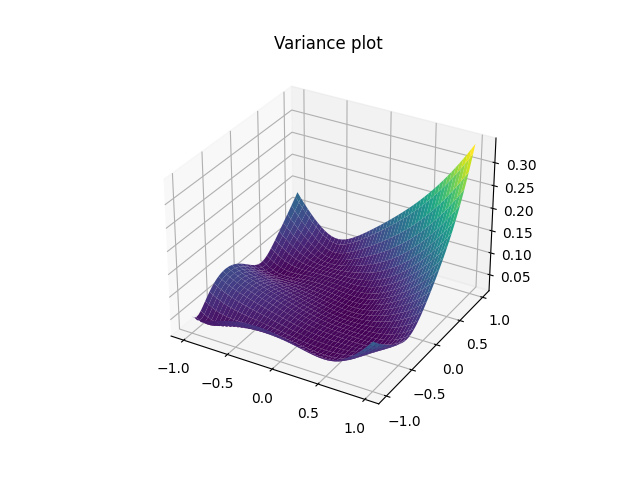

In [26]:

# Extracting only the diaginal elements: variance from covariance matrix
var = np.diag(cov).reshape(-1,1)

# converting from list of means to meshgrid format
pred_mean = mean.reshape(-1,1).reshape(num_div,num_div)
pred_var = var.reshape(-1,1).reshape(num_div,num_div)

beta = 10
upper_confidence_layer = pred_mean + beta*np.sqrt(pred_var)
lower_confidence_layer = pred_mean - beta*np.sqrt(pred_var)

# plot original points
plt.figure()
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(train_x0, train_y0, c=train_output0, vmin=0, vmax=5, s=35, cmap=cm)
plt.colorbar(sc)

# plotting mesh data
fig = plt.figure()
ax = plt.axes(projection='3d')
p1 = ax.plot_surface(X, Y, pred_mean, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
p2 = ax.plot_surface(X, Y, upper_confidence_layer, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
p3 = ax.plot_surface(X, Y, lower_confidence_layer, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
fig.colorbar(p1, shrink=0.5, aspect=5)
fig.colorbar(p2, shrink=0.5, aspect=5)
ax.set_title('surface');

#Plot only the variance
var_layer = np.sqrt(pred_var)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Variance plot')
p1 = ax.plot_surface(X, Y, var_layer, rstride=2, cstride=1,
                cmap='viridis', edgecolor='none')


## Process given data 1

In [ ]:
train_x1 = np.asarray([0.1, -0.9, 0.2, 0.8 ,-0.6, 0.3, 0.5, -0.5, -0.01, -0.9, 4.500000000000000111e-01, 7.199999999999999734e-01, -8.000000000000000444e-01, -8.000000000000000444e-01])
train_y1 = np.asarray([0.05, 0.3, 0.4, -0.3 ,0.3, -0.2 ,-0.84 ,0.85, -0.7, -0.9, 6.500000000000000222e-01, -6.400000000000000133e-01, -6.500000000000000222e-01, 5.999999999999999778e-01])
train_output1 = np.asarray([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928 ,2.7968011, 3.34929734, 3.9129616, 3.368086692765749124e+00, 3.752857874639865532e+00, 3.420476373601408770e+00, 3.040183158829708354e+00]).reshape(-1,1);
train_input1 = np.concatenate((train_x1.reshape(-1,1),train_y1.reshape(-1,1)),axis=1)

# generate test data
num_div = 50
x1 = np.linspace(-1,1,num_div)#.reshape(-1,1)
y1 = np.linspace(-1,1,num_div)#.reshape(-1,1)
X1, Y1 = np.meshgrid(x,y)

# converting from meshgrid format to a list of points
pred_input = np.concatenate((X1.reshape(-1,1),Y1.reshape(-1,1)),axis=1)

noise_cov = 0.001
mean_func = lambda x: np.zeros((x.shape[0],1))

params1 = train_gp()
# params = [1.0,3.0,3.0]
mean1, cov1 = gpr(train_input1, train_output1, pred_input, noise_cov * np.ones((train_input1.shape[0])), mean_func, sqexp, params1)
# mean, cov = gpr(train_input1, train_output1, pred_input, noise_cov * np.ones((train_input1.shape[0])), mean_func, sqexp)


/home/hardik/Dropbox (University of Michigan)/Semesters/Semester 3/AEROSP 567 Inf Est & Learning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:63: OptimizeWarning: Unknown solver options: xatol
/home/hardik/Dropbox (University of Michigan)/Semesters/Semester 3/AEROSP 567 Inf Est & Learning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log
/home/hardik/Dropbox (University of Michigan)/Semesters/Semester 3/AEROSP 567 Inf Est & Learning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log


         Current function value: 73.159843
         Iterations: 1
         Function evaluations: 21
         Gradient evaluations: 19


### Plot given data 1

In [ ]:

# Extracting only the diaginal elements: variance from covariance matrix
var1 = np.diag(cov1).reshape(-1,1)

# converting from list of means to meshgrid format
pred_mean1 = mean1.reshape(-1,1).reshape(num_div,num_div)
pred_var1 = var1.reshape(-1,1).reshape(num_div,num_div)

beta = 10
upper_confidence_layer1 = pred_mean1 + beta*np.sqrt(pred_var1)
lower_confidence_layer1 = pred_mean1 - beta*np.sqrt(pred_var1)

# plot original points
fig = plt.figure()
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(train_x1, train_y1, c=train_output1, vmin=0, vmax=5, s=35, cmap=cm)
fig.colorbar(sc)

# plotting mesh data
fig = plt.figure()
ax = plt.axes(projection='3d')
p1 = ax.plot_surface(X1, Y1, pred_mean1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
p2 = ax.plot_surface(X1, Y1, upper_confidence_layer1, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
p3 = ax.plot_surface(X1, Y1, lower_confidence_layer1, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
fig.colorbar(p1, shrink=0.5, aspect=5)
fig.colorbar(p2, shrink=0.5, aspect=5)
ax.set_title('surface');

#Plot only the variance
var_layer1 = np.sqrt(pred_var1)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Variance plot')
p1 = ax.plot_surface(X1, Y1, var_layer1, rstride=2, cstride=1,
                cmap='viridis', edgecolor='none')


In [ ]:
#Plot only the variance
fig = plt.figure()
var_layer = np.sqrt(pred_var)
ax = plt.axes(projection='3d')
ax.set_title('Variance plot')
p1 = ax.plot_surface(X1, Y1, var_layer, rstride=2, cstride=1,
                cmap='plasma', edgecolor='none')
fig.colorbar(p1, shrink=0.5, aspect=5)

In [ ]:
np.amax(upper_confidence_layer)

In [ ]:
np.where(upper_confidence_layer == np.amax(upper_confidence_layer))

In [ ]:
upper_confidence_layer[0,49]